In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import PIL
import PIL.Image

/Users/boubalkaly/Desktop/brain-tumor/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [19]:
#load the training and testing datasets
training_dir = './cleaned/Training'
testing_dir = './cleaned/Testing'
training_set = tf.keras.utils.image_dataset_from_directory(training_dir)
testing_set = tf.keras.utils.image_dataset_from_directory(testing_dir)

class_names = training_set.class_names
print(class_names)


    

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
['glioma', 'meningioma', 'notumor', 'pituitary']


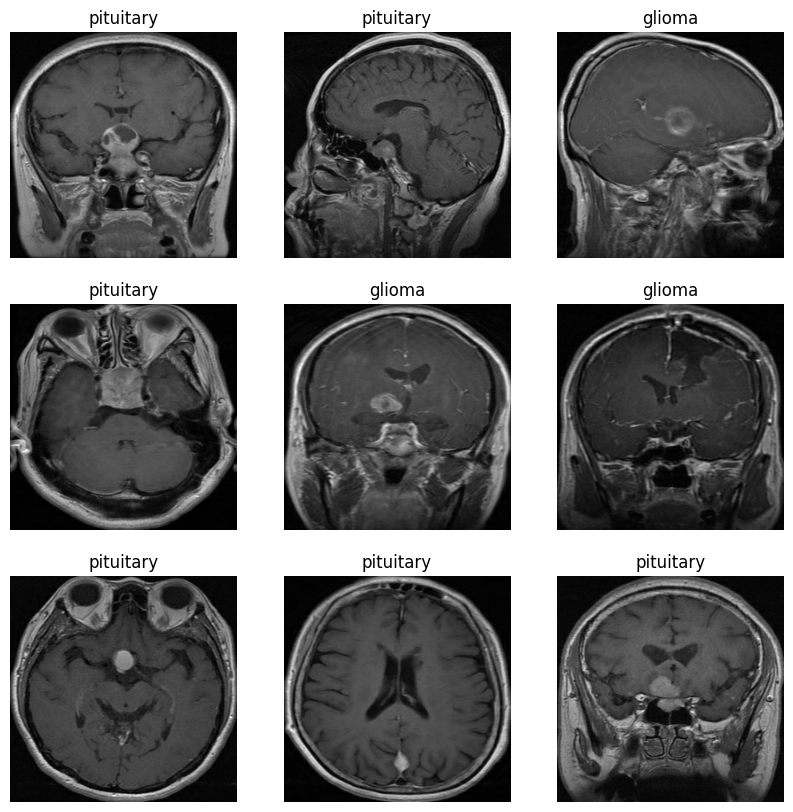

In [22]:
#now we are doing to do some data visualization

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')



        
    
    

In [23]:
#now we are going to standardize the data in order to make it more compatible for a neural network
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_traning_set = training_set.map(lambda x, y: (normalization_layer(x), y))
normalized_testing_set = training_set.map(lambda x, y: (normalization_layer(x), y))